In [4]:
import tensorflow as tf
import tensorflow_hub as hub
#import tensorflow_text as text

In [5]:
import pandas as pd

df = pd.read_csv("Corona_NLP_test.csv")
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [6]:
df.groupby('Sentiment').describe()

UserName               ... ScreenName         
                      count         mean  ...        75%      max
Sentiment                                 ...                    
Extremely Negative    592.0  1949.851351  ...   47842.75  48749.0
Extremely Positive    599.0  1919.243740  ...   47930.50  48750.0
Negative             1041.0  1828.076849  ...   47676.00  48747.0
Neutral               619.0  1939.915994  ...   47879.50  48748.0
Positive              947.0  1907.630412  ...   47781.50  48746.0

[5 rows x 16 columns]

In [7]:
df['Sentiment'].value_counts()

Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: Sentiment, dtype: int64

In [8]:
df_negative = df[df['Sentiment']=='Negative']
df_negative.shape

(1041, 6)

In [9]:
df_positive = df[df['Sentiment']=='Positive']
df_positive.shape

(947, 6)

In [10]:
df_neutral = df[df['Sentiment']=='Neutral']
df_neutral.shape

(619, 6)

In [11]:
df_extremely_positive = df[df['Sentiment']=='Extremely Positive']
df_extremely_positive.shape

(599, 6)

In [12]:
df_extremely_negative = df[df['Sentiment']=='Extremely Negative']
df_extremely_negative.shape

(592, 6)

In [13]:
df_positive_downsampled = df_positive.sample(df_positive.shape[0])
df_positive_downsampled.shape

(947, 6)

In [14]:
df_balanced = pd.concat([df_positive_downsampled, df_negative, df_neutral, df_extremely_positive, df_extremely_negative])
df_balanced.shape

(3798, 6)

In [15]:
df_balanced['Sentiment'].value_counts()

Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: Sentiment, dtype: int64

In [16]:
df_balanced['Negative']=df_balanced['Sentiment'].apply(lambda x: 1 if x=='Negative' or x=='Extremely Negative'  else 0)
df_balanced.sample(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Negative
3156,3157,48109,Toronto,15-03-2020,COVID-19 is not helping me curb my unhealthy o...,Extremely Negative,1
157,158,45110,??,11-03-2020,Going out on a food raid. Chos. When ur househ...,Negative,1
887,888,45840,"Nairobi, Kenya",12-03-2020,Catching flights and not feelings... The price...,Negative,1
2610,2611,47563,Chesapeake region,14-03-2020,Ive broken many of the #COVID2019 #COVID?19 #...,Extremely Positive,0
1224,1225,46177,Boston,13-03-2020,The one who stayed away saved all the rest\r\r...,Extremely Positive,0
3021,3022,47974,NaN,15-03-2020,This quarantine has really lit a fire to my al...,Extremely Negative,1
625,626,45578,"Los Angeles County, CA",12-03-2020,We're here to help answer your #consumer quest...,Positive,0
626,627,45579,"City of Angels, CA",12-03-2020,The #WalkingDead has taught me 1) no evidence ...,Extremely Positive,0
410,411,45363,NaN,12-03-2020,Today my mother tried to barter her chicken fo...,Negative,1
3165,3166,48118,"Arkansas, USA",15-03-2020,So were shutting down schools and bars all ov...,Negative,1


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['OriginalTweet'],df_balanced['Negative'], stratify=df_balanced['Negative'])

In [18]:
X_train.head(4)

85      Q1 #earnings are expected to be heavily impact...
3464    Today, I talk US #retail store closings due to...
2923    @tjricky @betaekonano @jokowi @KemenkesRI @ani...
2939    i kinda want to go to walmart or some grocery ...
Name: OriginalTweet, dtype: object

In [19]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

FileNotFoundError: ignored

In [20]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

NameError: ignored

In [ ]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

In [ ]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703803]], dtype=float32)

In [ ]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872036]], dtype=float32)

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [21]:
model.summary()

NameError: ignored

In [ ]:
len(X_train)

2848

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
89/89 [==============================] - 516s 5s/step - loss: 0.6970 - accuracy: 0.5481 - precision: 0.4505 - recall: 0.2302
Epoch 2/10
89/89 [==============================] - 462s 5s/step - loss: 0.6966 - accuracy: 0.5488 - precision: 0.4522 - recall: 0.2318
Epoch 3/10
89/89 [==============================] - 472s 5s/step - loss: 0.6896 - accuracy: 0.5632 - precision: 0.4831 - recall: 0.2220
Epoch 4/10
89/89 [==============================] - 494s 6s/step - loss: 0.6837 - accuracy: 0.5692 - precision: 0.4985 - recall: 0.2686
Epoch 5/10
89/89 [==============================] - 541s 6s/step - loss: 0.6823 - accuracy: 0.5779 - precision: 0.5172 - recall: 0.2816
Epoch 6/10
89/89 [==============================] - 553s 6s/step - loss: 0.6768 - accuracy: 0.5850 - precision: 0.5342 - recall: 0.2743
Epoch 7/10
89/89 [==============================] - 501s 6s/step - loss: 0.6825 - accuracy: 0.5787 - precision: 0.5147 - recall: 0.3567
Epoch 8/10
89/89 [==============================

In [ ]:
model.evaluate(X_test, y_test)

30/30 [==============================] - 185s 5s/step - loss: 0.6642 - accuracy: 0.5926 - precision: 0.7143 - recall: 0.0858


[0.6642091274261475,
 0.5926315784454346,
 0.7142857313156128,
 0.08578431606292725]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:

import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[528,  14],
       [373,  35]], dtype=int64)

Text(33.0, 0.5, 'Truth')

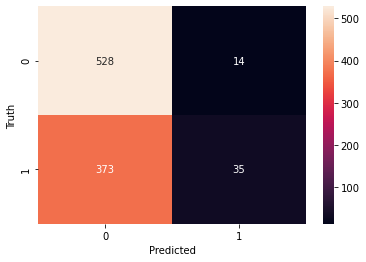

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.59      0.97      0.73       542
           1       0.71      0.09      0.15       408

    accuracy                           0.59       950
   macro avg       0.65      0.53      0.44       950
weighted avg       0.64      0.59      0.48       950

